# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

C:\Users\Satya\AppData\Local\Temp\ipykernel_13192\2758223681.py:2: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
C:\Users\Satya\AppData\Local\Temp\ipykernel_13192\2758223681.py:3: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')


In [3]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB


In [4]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 369 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(8)
memory usage: 539.5+ MB


Check the values in the Columns that threw up a warning when we loaded the csv files.

In [5]:
attributes = load_info('data/DIAS Attributes - Values 2017.xlsx', skiprows=1)

In [6]:
attributes.head()

,Attribute,Description,Value,Meaning,Missing
0,AGER_TYP,best-ager typology,-1,unknown,True
1,AGER_TYP,best-ager typology,0,no classification possible,False
2,AGER_TYP,best-ager typology,1,passive elderly,False
3,AGER_TYP,best-ager typology,2,cultural elderly,False
4,AGER_TYP,best-ager typology,3,experience-driven elderly,False


In [7]:
# Gettig the name of the columns that read_csv warned about having mixed data types
azdias.columns[18:20]

Index(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'], dtype='object')

In [8]:
def find_columns(col_string, df):
    return df.columns[df.columns.str.contains(col_string)]

In [9]:
find_columns('CAMEO', azdias)

Index(['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015'], dtype='object')

In [10]:
get_attributes('CAMEO', attributes)

['CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_DEUINTL_2015']

In [11]:
# The value 'CAMEO_DEUINTL_2015' in attributes excel corresponds to the column 'CAMEO_INTL_2015'
attributes.replace({'Attribute':{'CAMEO_DEUINTL_2015':'CAMEO_INTL_2015'}}, inplace=True)

In [12]:
cameo_cols = get_attributes('CAMEO', attributes)

In [13]:
for col in cameo_cols:
    get_unique_vals(azdias, col)

Unique Values in Column CAMEO_DEUG_2015:  [nan 8.0 4.0 2.0 6.0 1.0 9.0 5.0 7.0 3.0 '4' '3' '7' '2' '8' '9' '6' '5'
 '1' 'X']
Unique Values in Column CAMEO_DEU_2015:  [nan '8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D'
 '9E' '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C'
 '9C' '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F'
 '5F' '1C' 'XX']
Unique Values in Column CAMEO_INTL_2015:  [nan 51.0 24.0 12.0 43.0 54.0 22.0 14.0 13.0 15.0 33.0 41.0 34.0 55.0 25.0
 23.0 31.0 52.0 35.0 45.0 44.0 32.0 '22' '24' '41' '12' '54' '51' '44'
 '35' '23' '25' '14' '34' '52' '55' '31' '32' '15' '13' '43' '33' '45'
 'XX']


In [14]:
for col in cameo_cols:
    get_unique_vals(customers, col)

Unique Values in Column CAMEO_DEUG_2015:  [1.0 nan 5.0 4.0 7.0 3.0 9.0 2.0 6.0 8.0 '6' '3' '8' '9' '2' '4' '1' '7'
 '5' 'X']
Unique Values in Column CAMEO_DEU_2015:  ['1A' nan '5D' '4C' '7B' '3B' '1D' '9E' '2D' '4A' '6B' '9D' '8B' '5C' '9C'
 '4E' '6C' '8C' '8A' '5B' '9B' '3D' '2A' '3C' '5F' '7A' '1E' '2C' '7C'
 '5A' '2B' '6D' '7E' '5E' '6E' '3A' '9A' '4B' '1C' '1B' '6A' '8D' '7D'
 '6F' '4D' 'XX']
Unique Values in Column CAMEO_INTL_2015:  [13.0 nan 34.0 24.0 41.0 23.0 15.0 55.0 14.0 22.0 43.0 51.0 33.0 25.0 44.0
 54.0 32.0 12.0 35.0 31.0 45.0 52.0 '45' '25' '55' '51' '14' '54' '43'
 '22' '15' '24' '35' '23' '12' '44' '41' '52' '31' '13' '34' '32' '33'
 'XX']


Replace the **X** or **XX** values with NaNs

In [15]:
import types

In [16]:
from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline, Pipeline

In [17]:
class Clean:
    
    def __init__(self, df):
        self.clean_proc = {}
        self.df = df
        self.cols_dropped = []
        
    def remap(self, col, map_dict):
        if col in self.clean_proc.keys():
            self.clean_proc[col].append(('replace', map_dict))
        else:
            self.clean_proc[col] = [('replace', map_dict)]
        return self.df[col].replace(map_dict)
    
    def reapply(self, col, transformation):
        if col in self.clean_proc.keys():
            self.clean_proc[col].append(('apply', transformation))
        else:
            self.clean_proc[col]= [('apply', transformation)]
        return self.df[col].apply(transformation)

    def drop_cols(self, df, col):
        self.cols_dropped.append(col)
        df.drop(col, axis=1, inplace=True)

    def fit(self, col, map_transform):
        if type(map_transform) == types.FunctionType:
            self.reapply(col, map_transform)
        if type(map_transform) == dict:
            self.remap(col, map_transform)

    def transform(self, df=None):
        if isinstance(df, pd.DataFrame):
            df_transformed = df
        elif df == None:
            df_transformed = self.df
        for col, map_transforms in self.clean_proc.items():
            if ((col in self.cols_dropped)|(col not in df_transformed.columns)):
                continue
            else:
                for map_transform in map_transforms:
                    if map_transform[0] == 'replace':
                        df_transformed[col] = df_transformed[col].replace(map_transform[1])
                    if map_transform[0] == 'apply':
                        df_transformed[col] = df_transformed[col].apply(map_transform[1])
        # return df_transformed

    def fit_transform(self, col, map_transform):
        if type(map_transform) == types.FunctionType:
            self.df[col] = self.reapply(col, map_transform)
        if type(map_transform) == dict:
            self.df[col] = self.remap(col, map_transform)

In [18]:
clean_data = Clean(azdias)

In [19]:
clean_data.fit_transform('CAMEO_DEUG_2015', {'X': np.nan})
get_unique_vals(azdias, 'CAMEO_DEUG_2015')

Unique Values in Column CAMEO_DEUG_2015:  [nan 8.0 4.0 2.0 6.0 1.0 9.0 5.0 7.0 3.0 '4' '3' '7' '2' '8' '9' '6' '5'
 '1']


In [20]:
clean_data.fit_transform('CAMEO_INTL_2015', {'XX': np.nan})
get_unique_vals(azdias, 'CAMEO_INTL_2015')

Unique Values in Column CAMEO_INTL_2015:  [nan 51.0 24.0 12.0 43.0 54.0 22.0 14.0 13.0 15.0 33.0 41.0 34.0 55.0 25.0
 23.0 31.0 52.0 35.0 45.0 44.0 32.0 '22' '24' '41' '12' '54' '51' '44'
 '35' '23' '25' '14' '34' '52' '55' '31' '32' '15' '13' '43' '33' '45']


In [21]:
clean_data.fit_transform('CAMEO_DEU_2015', {'XX': np.nan})
get_unique_vals(azdias, 'CAMEO_DEU_2015')

Unique Values in Column CAMEO_DEU_2015:  [nan '8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D'
 '9E' '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C'
 '9C' '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F'
 '5F' '1C']


Convert string values to int so that the columns have right dtype

In [22]:
azdias.iloc[:, 18:20].dtypes

CAMEO_DEUG_2015    object
CAMEO_INTL_2015    object
dtype: object

'CAMEO_DEUG_2015', 'CAMEO_INTL_2015'

In [23]:
clean_data.fit_transform('CAMEO_DEUG_2015', lambda x: eval(x) if type(x)==str else x)

In [24]:
clean_data.fit_transform('CAMEO_INTL_2015', lambda x: eval(x) if type(x)==str else x)

In [25]:
attributes.head()

,Attribute,Description,Value,Meaning,Missing
0,AGER_TYP,best-ager typology,-1,unknown,True
1,AGER_TYP,best-ager typology,0,no classification possible,False
2,AGER_TYP,best-ager typology,1,passive elderly,False
3,AGER_TYP,best-ager typology,2,cultural elderly,False
4,AGER_TYP,best-ager typology,3,experience-driven elderly,False


In [26]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [27]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [36]:
attributes.head()

,Attribute,Description,Value,Meaning,Missing
0,AGER_TYP,best-ager typology,-1,unknown,True
1,AGER_TYP,best-ager typology,0,no classification possible,False
2,AGER_TYP,best-ager typology,1,passive elderly,False
3,AGER_TYP,best-ager typology,2,cultural elderly,False
4,AGER_TYP,best-ager typology,3,experience-driven elderly,False


Create a column to indicate missing values info

In [36]:
attributes['Missing'].unique()

array([True, False, nan], dtype=object)

In [37]:
unknowns = attributes[attributes.Missing == True]

unknowns.reset_index(inplace=True, drop=True)

unknowns.head()

,Attribute,Description,Value,Meaning,Missing
0,AGER_TYP,best-ager typology,-1,unknown,True
1,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown,True
2,ALTER_HH,main age within the household,0,unknown / no main age detectable,True
3,ANREDE_KZ,gender,"-1, 0",unknown,True
4,BALLRAUM,distance to next urban centre,-1,unknown,True


Fix the values in the Value column so that they all have a uniform pattern

In [38]:
def create_missing_val_list(x):
    if type(x)!=int:
        return [int(i) for i in x.split(',')]
    else:
        return [x]

In [39]:
unknowns.loc[:, 'Val'] = unknowns.Value.apply(create_missing_val_list)

C:\Users\Satya\AppData\Local\Temp\ipykernel_13192\2899877996.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknowns.loc[:, 'Val'] = unknowns.Value.apply(create_missing_val_list)


In [40]:
unknowns_dict = {v.Attribute: {val: np.nan for val in v.Val} for _, v in unknowns.iterrows()}

In [41]:
len(unknowns_dict.keys())

233

In [42]:
for col, map_dict in unknowns_dict.items():
    if col in azdias.columns:
        clean_data.fit_transform(col, map_dict)
    else:
        print(col)

BIP_FLAG
D19_KK_KUNDENTYP
GEOSCORE_KLS7
HAUSHALTSSTRUKTUR
KBA13_CCM_1400_2500
SOHO_FLAG
WACHSTUMSGEBIET_NB


In [43]:
# customers.replace(unknowns_dict, inplace=True)

In [44]:
# azdias.replace(unknowns_dict, inplace=True)

Categorical Features or columns can be identified using three approaches:
- columns with dtype object in the dataframe
- columns containing the string 'klasse' or 'typ' in their name
- columns mentioned in the attribute file with the words classification or typology in their description

Out of all the potential categorical columns obtained using the above methods, some of them already might be in an encoded format, while some might need further transformation or contain information that could be made into a different columns altogether.

In [45]:
categorical_attributes_info = attributes.loc[attributes.Value.apply(lambda x: (type(x)==str) & (x!='-1, 0') & (x!='-1, 9')), :]
categorical_attributes_info = categorical_attributes_info.reset_index(drop=True)

In [46]:
categorical_attributes_info.head()

,Attribute,Description,Value,Meaning,Missing
0,ANZ_HAUSHALTE_AKTIV,number of households in the building,…,numeric value (typically coded from 1-10),False
1,ANZ_HH_TITEL,number of academic title holder in building,…,numeric value (typically coded from 1-10),False
2,ANZ_PERSONEN,number of adult persons in the household,…,numeric value (typically coded from 1-3),False
3,ANZ_TITEL,number of professional title holder in household,…,numeric value (typically coded from 1-10),False
4,CAMEO_DEU_2015,CAMEO classification 2015 - detailled classifi...,1A,Work-Life-Balance,False


In [47]:
categorical_attributes_info.loc[1, 'Value']

'…'

In [48]:
categorical_attributes_info = categorical_attributes_info[categorical_attributes_info.Value!='…']
categorical_attributes = categorical_attributes_info.Attribute.unique()
categorical_attributes

array(['CAMEO_DEU_2015', 'ORTSGR_KLS9', 'OST_WEST_KZ'], dtype=object)

In [49]:
binary_attrib = attributes.query("Missing == False").groupby('Attribute').size()
binary_attrib_index = binary_attrib[binary_attrib  == 2].index

In [50]:
binary_attributes_info = attributes.loc[attributes.Attribute.apply(lambda x: x in binary_attrib_index), :].query("Missing == False")
binary_attributes_info.reset_index(inplace=True, drop=True)

In [51]:
binary_attributes_info.head()

,Attribute,Description,Value,Meaning,Missing
0,ANREDE_KZ,gender,1,male,False
1,ANREDE_KZ,gender,2,female,False
2,BIP_FLAG,business-flag indicating companies in the buil...,0,no company in the building,False
3,BIP_FLAG,business-flag indicating companies in the buil...,1,company in the building,False
4,GREEN_AVANTGARDE,Green avantgarde,0,doesn't belong to the green avantgarde,False


In [52]:
categorical_cols = set(list(categorical_attributes_info.Attribute.unique()) + list(binary_attributes_info.Attribute.unique()))

In [53]:
typ_attributes = attributes.loc[attributes.Attribute.str.contains('TYP'), :]
klasse_attributes = attributes.loc[attributes.Attribute.str.contains('KLASSE'), :]
    
attributes_typ_descr = attributes.loc[attributes.Description.str.contains('typ'), :]
attributes_class_descr = attributes.loc[attributes.Description.str.contains('class'), :]    

In [54]:
cols_cat = azdias.select_dtypes(exclude=np.number).columns
cols_cat

Index(['CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM',
       'OST_WEST_KZ'],
      dtype='object')

In [55]:
attributes[attributes['Attribute']=='ANREDE_KZ']

,Attribute,Description,Value,Meaning,Missing
33,ANREDE_KZ,gender,"-1, 0",unknown,True
34,ANREDE_KZ,gender,1,male,False
35,ANREDE_KZ,gender,2,female,False


In [56]:
clean_data.fit_transform('ANREDE_KZ', {1:0, 2:1})

In [57]:
attributes[attributes.Attribute=='OST_WEST_KZ']

,Attribute,Description,Value,Meaning,Missing
2013,OST_WEST_KZ,flag indicating the former GDR/FRG,-1,unknown,True
2014,OST_WEST_KZ,flag indicating the former GDR/FRG,O,East (GDR),False
2015,OST_WEST_KZ,flag indicating the former GDR/FRG,W,West (FRG),False


In [58]:
clean_data.fit_transform('OST_WEST_KZ',{'O':0, 'W':1})

In [59]:
azdias[['D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM']].head()

,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM
0,NaN,NaN
1,NaN,1992-02-10 00:00:00
2,D19_UNBEKANNT,1992-02-12 00:00:00
3,D19_UNBEKANNT,1997-04-21 00:00:00
4,D19_SCHUHE,1992-02-12 00:00:00


In [60]:
cols_cameo = list(attributes[attributes.Attribute.str.contains('CAMEO')].Attribute.unique())

In [61]:
cols_cameo

['CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015']

In [62]:
categorical_cols

{'ANREDE_KZ',
 'BIP_FLAG',
 'CAMEO_DEU_2015',
 'GREEN_AVANTGARDE',
 'KBA05_SEG6',
 'ORTSGR_KLS9',
 'OST_WEST_KZ',
 'SOHO_FLAG',
 'VERS_TYP'}

In [63]:
attributes[attributes.Attribute == 'VERS_TYP']

,Attribute,Description,Value,Meaning,Missing
2216,VERS_TYP,insurance typology,-1,unknown,True
2217,VERS_TYP,insurance typology,1,social-safety driven,False
2218,VERS_TYP,insurance typology,2,individualistic-accepting risks,False


In [64]:
azdias['LP_FAMILIE_GROB'].unique()

array([ 2.,  3.,  1.,  0.,  5.,  4., nan])

In [65]:
customers['LP_FAMILIE_GROB'].unique()

array([ 2., nan,  1.,  0.,  5.,  4.,  3.])

In [66]:
attributes[attributes.Attribute == 'LP_FAMILIE_GROB']

,Attribute,Description,Value,Meaning,Missing
1903,LP_FAMILIE_GROB,familytyp rough,1,single,False
1904,LP_FAMILIE_GROB,familytyp rough,2,couple,False
1905,LP_FAMILIE_GROB,familytyp rough,3,single parent,False
1906,LP_FAMILIE_GROB,familytyp rough,4,NaN,NaN
1907,LP_FAMILIE_GROB,familytyp rough,5,NaN,NaN
1908,LP_FAMILIE_GROB,familytyp rough,6,family,False
1909,LP_FAMILIE_GROB,familytyp rough,7,NaN,NaN
1910,LP_FAMILIE_GROB,familytyp rough,8,NaN,NaN
1911,LP_FAMILIE_GROB,familytyp rough,9,multiperson household,False
1912,LP_FAMILIE_GROB,familytyp rough,10,NaN,NaN


In [67]:
clean_data.fit_transform('LP_FAMILIE_GROB', {0:np.nan})

In [68]:
azdias['LP_FAMILIE_FEIN'].unique()

array([ 2.,  5.,  1.,  0., 10.,  7., 11.,  3.,  8.,  4.,  6., nan,  9.])

In [69]:
customers['LP_FAMILIE_FEIN'].unique()

array([ 2., nan,  1.,  0., 10.,  8.,  6., 11.,  9.,  7.,  5.,  3.,  4.])

In [70]:
clean_data.fit_transform('LP_FAMILIE_FEIN', {0:np.nan})

In [71]:
azdias['LP_LEBENSPHASE_GROB'].unique()

array([ 4.,  6.,  1.,  0., 10.,  2.,  3.,  5.,  7., 12., 11.,  9.,  8.,
       nan])

In [72]:
customers['LP_LEBENSPHASE_GROB'].unique()

array([ 5., nan,  3.,  0., 10.,  2.,  8., 12., 11.,  1.,  4.,  6.,  7.,
        9.])

In [73]:
attributes[attributes.Attribute == 'LP_LEBENSPHASE_GROB']

,Attribute,Description,Value,Meaning,Missing
1954,LP_LEBENSPHASE_GROB,lifestage rough,1,single low-income- and average earners of youn...,False
1955,LP_LEBENSPHASE_GROB,lifestage rough,2,single low-income- and average earners of high...,False
1956,LP_LEBENSPHASE_GROB,lifestage rough,3,single high-income earners,False
1957,LP_LEBENSPHASE_GROB,lifestage rough,4,single low-income- and average earner-couples,False
1958,LP_LEBENSPHASE_GROB,lifestage rough,5,single high-income earner-couples,False
1959,LP_LEBENSPHASE_GROB,lifestage rough,6,single parents,False
1960,LP_LEBENSPHASE_GROB,lifestage rough,7,single low-income- and average earner-families,False
1961,LP_LEBENSPHASE_GROB,lifestage rough,8,high-income earner-families,False
1962,LP_LEBENSPHASE_GROB,lifestage rough,9,average earners of younger age from mulitperso...,False
1963,LP_LEBENSPHASE_GROB,lifestage rough,10,low-income- and average earners of higher age ...,False


In [74]:
clean_data.fit_transform('LP_LEBENSPHASE_GROB', {0:np.nan})

In [75]:
azdias['LP_LEBENSPHASE_FEIN'].unique()

array([15., 21.,  3.,  0., 32.,  8.,  2.,  5., 10.,  4.,  6., 23., 12.,
       20.,  1., 11., 25., 13.,  7., 18., 31., 19., 38., 35., 30., 22.,
       14., 33., 29., 24., 28., 37., 26., 39., 27., 36.,  9., 34., nan,
       40., 16., 17.])

In [76]:
customers['LP_LEBENSPHASE_FEIN'].unique()

array([20., nan, 13.,  0., 31., 17.,  6., 28.,  5., 27., 40., 35.,  2.,
       19., 38., 36.,  8., 34., 10., 12., 26., 11.,  9., 37., 14., 39.,
       32.,  7., 15., 23., 21., 25., 33., 16., 24., 30., 18.,  4., 22.,
        1., 29.,  3.])

In [77]:
attributes[attributes.Attribute == 'LP_LEBENSPHASE_FEIN']

,Attribute,Description,Value,Meaning,Missing
1914,LP_LEBENSPHASE_FEIN,lifestage fine,1,single low-income earners of younger age,False
1915,LP_LEBENSPHASE_FEIN,lifestage fine,2,single low-income earners of middle age,False
1916,LP_LEBENSPHASE_FEIN,lifestage fine,3,single average earners of younger age,False
1917,LP_LEBENSPHASE_FEIN,lifestage fine,4,single average earners of middle age,False
1918,LP_LEBENSPHASE_FEIN,lifestage fine,5,single low-income earners of advanced age,False
1919,LP_LEBENSPHASE_FEIN,lifestage fine,6,single low-income earners at retirement age,False
1920,LP_LEBENSPHASE_FEIN,lifestage fine,7,single average earners of advanced age,False
1921,LP_LEBENSPHASE_FEIN,lifestage fine,8,single average earners at retirement age,False
1922,LP_LEBENSPHASE_FEIN,lifestage fine,9,single independant persons,False
1923,LP_LEBENSPHASE_FEIN,lifestage fine,10,wealthy single homeowners,False


In [78]:
clean_data.fit_transform('LP_LEBENSPHASE_FEIN', {0:np.nan})

In [79]:
attributes.query("Meaning == 'no score calculated'")

,Attribute,Description,Value,Meaning,Missing
2230,WOHNLAGE,residential-area,0,no score calculated,False


In [80]:
attributes.query("Attribute == 'WOHNLAGE'")

,Attribute,Description,Value,Meaning,Missing
2229,WOHNLAGE,residential-area,-1,unknown,True
2230,WOHNLAGE,residential-area,0,no score calculated,False
2231,WOHNLAGE,residential-area,1,very good neighbourhood,False
2232,WOHNLAGE,residential-area,2,good neighbourhood,False
2233,WOHNLAGE,residential-area,3,average neighbourhood,False
2234,WOHNLAGE,residential-area,4,poor neighbourhood,False
2235,WOHNLAGE,residential-area,5,very poor neighbourhood,False
2236,WOHNLAGE,residential-area,7,rural neighbourhood,False
2237,WOHNLAGE,residential-area,8,new building in rural neighbourhood,False


In [81]:
clean_data.fit_transform('WOHNLAGE', {0:np.nan})

In [82]:
# later
clean_data.transform(customers)

Check columns that might be specific to a particular dataframe and refer the attributes file for more info

In [83]:
set(customers.columns) - set(azdias.columns)

{'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'}

In [84]:
len(set(azdias.columns) & set(attributes.Attribute) & set(customers.columns))

273

In [85]:
len(set(attributes.Attribute))

314

In [86]:
attributes_notin_df = set(attributes.Attribute) - set(customers.columns)

In [87]:
customers.CUSTOMER_GROUP.unique()

array(['MULTI_BUYER', 'SINGLE_BUYER'], dtype=object)

In [88]:
customers.PRODUCT_GROUP.unique()

array(['COSMETIC_AND_FOOD', 'FOOD', 'COSMETIC'], dtype=object)

In [89]:
customers.ONLINE_PURCHASE.unique()

array([0, 1], dtype=int64)

For now we will drop the customer specific columns. We can always perform a join post cleaning and add the required values back.

In [90]:
cols_to_drop = list(set(customers.columns) - set(azdias.columns))

In [91]:
cols_to_drop

['ONLINE_PURCHASE', 'CUSTOMER_GROUP', 'PRODUCT_GROUP']

In [92]:
# later
customers.drop(cols_to_drop, axis=1, inplace=True)

After Replacing NaNs

Figure out the optimum percentage of NaN threshold such that both dataframes end up with same number of columns being dropped

In [93]:
customers_missing_val = customers.isnull().sum() / len(customers)
customers_missing_val = customers_missing_val[customers_missing_val>0]

In [94]:
azdias_missing_val = azdias.isnull().sum() / len(azdias)
azdias_missing_val = azdias_missing_val[azdias_missing_val>0]

In [95]:
customers_cols_to_drop = customers_missing_val[customers_missing_val > 0.30].index

In [96]:
azdias_cols_to_drop = azdias_missing_val[azdias_missing_val > 0.30].index

In [97]:
customers_cols_to_drop

Index(['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3',
       'ALTER_KIND4', 'EXTSEL992', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'KKK',
       'REGIOTYP', 'TITEL_KZ'],
      dtype='object')

In [98]:
azdias_cols_to_drop

Index(['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3',
       'ALTER_KIND4', 'EXTSEL992', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'TITEL_KZ'],
      dtype='object')

In [99]:
set(customers_cols_to_drop) - set(azdias_cols_to_drop)

{'KKK', 'REGIOTYP'}

In [100]:
customers_missing_val[(customers_missing_val.index == 'KKK') | (customers_missing_val.index =='REGIOTYP')]

KKK         0.313401
REGIOTYP    0.313401
dtype: float64

In [102]:
# later
customers.dropna(thresh=0.66*len(customers), axis=1, inplace=True)

In [103]:
customers.shape

(191652, 356)

In [104]:
# later
azdias.dropna(thresh=0.66*len(azdias), axis=1, inplace=True)

In [105]:
azdias.shape

(891221, 356)

In [106]:
set(azdias.columns) == set(customers.columns)

True

Let us look at the number of missing values per row and then construct a hist to check both dataframes

In [107]:
azdias_missing_rows = azdias.isnull().sum(axis=1)
azdias_missing_rows = azdias_missing_rows[azdias_missing_rows>0]

In [108]:
customers_missing_rows = customers.isnull().sum(axis=1)
customers_missing_rows = customers_missing_rows[customers_missing_rows>0]

Visualizing the missing data is a much better option than a significance test like MCAR at this point.

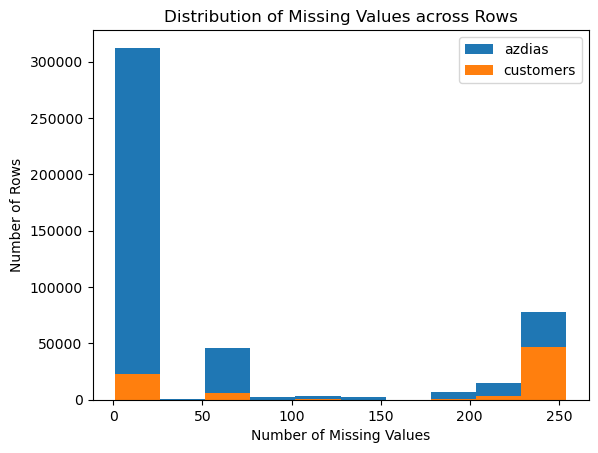

In [109]:
plt.hist(azdias_missing_rows.values, label='azdias')
plt.hist(customers_missing_rows.values, label='customers')
plt.xlabel('Number of Missing Values')
plt.ylabel('Number of Rows')
plt.legend()
plt.title('Distribution of Missing Values across Rows');

In [110]:
len_50_perccent_cols = (50/100)*azdias.shape[1]
len_70_perccent_cols = (70/100)*azdias.shape[1]
len_50_perccent_cols, len_70_perccent_cols

(178.0, 249.2)

In [111]:
missingno=100
(len(customers_missing_rows[customers_missing_rows>missingno])/customers.shape[0])*100

26.75735186692547

In [112]:
(len(customers_missing_rows[customers_missing_rows>missingno])/len(customers_missing_rows))*100

63.79662113408474

In [113]:
missingno=100
(len(azdias_missing_rows[azdias_missing_rows>missingno])/azdias.shape[0])*100

11.87225166372875

In [114]:
(len(azdias_missing_rows[azdias_missing_rows>missingno])/len(azdias_missing_rows))*100

22.649102452682367

In [115]:
na_threshold_rows = np.ceil(len_70_perccent_cols)

In [116]:
azdias.dropna(thresh=na_threshold_rows, axis=0, inplace=True)

customers.dropna(thresh=na_threshold_rows, axis=0, inplace=True)

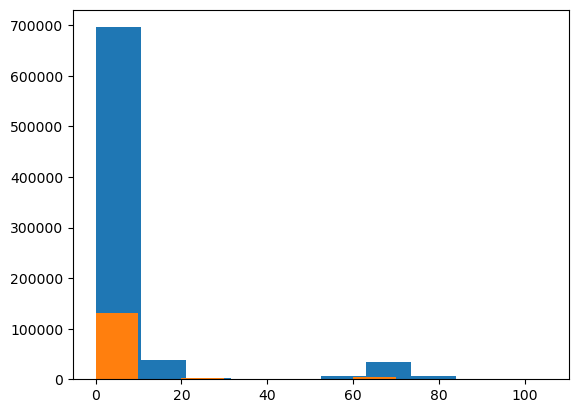

In [117]:
plt.hist(azdias.isnull().sum(axis=1).values)
plt.hist(customers.isnull().sum(axis=1).values);

In [118]:
class FeatureEngineer:
    
    def __init__(self, *args):
        self.trans_dicts = {}
        self.func_dicts = {}
        self.map_dicts = {}
        self.args = args
        
    def make_feature(self, new_col, from_col, transformation):
        self.trans_dicts[from_col] = {new_col:transformation}
        for df in self.args:
            df[new_col] = df[from_col].apply(transformation)
            
    def apply_func(self, new_col, from_col, func):
        self.func_dicts[from_col] = {new_col:func}
        for df in self.args:
            df[new_col] = func(df, from_col)
            
    def remap(self, new_col, from_col, map_dict):
        self.map_dicts[from_col] = {new_col:map_dict}
        for df in self.args:
            df[new_col] = df[from_col].replace(map_dict) 

In [119]:
feature_engine = FeatureEngineer(azdias, customers)

In [120]:
feature_engine.make_feature('CAMEO_INTL_HH_ECON', cols_cameo[2], lambda x: x//10)

In [121]:
feature_engine.make_feature('CAMEO_INTL_FAM_INFO', cols_cameo[2], lambda x: x%10)

In [122]:
azdias.select_dtypes(exclude=np.number).columns

Index(['CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM'], dtype='object')

In [123]:
azdias['CAMEO_DEU_2015'].unique()

array(['8A', '4C', '2A', '6B', '8C', '4A', '2D', '1A', '1E', '9D', '5C',
       '7A', '5D', '9E', '9B', '1B', '8B', '3D', nan, '4E', '4B', '3C',
       '5A', '7B', '9A', '6D', '6E', '2C', '7C', '9C', '7D', '5E', '1D',
       '8D', '6C', '6A', '5B', '4D', '3A', '2B', '7E', '3B', '6F', '5F',
       '1C'], dtype=object)

In [124]:
customers['CAMEO_DEU_2015'].unique()

array(['1A', '5D', '4C', '7B', '3B', '1D', '9E', '2D', '4A', '6B', '9D',
       '8B', '5C', '9C', '4E', '6C', '8C', '8A', '5B', '9B', '3D', '2A',
       '3C', '5F', '7A', '1E', '2C', '7C', '5A', '2B', '6D', '7E', '5E',
       '6E', '3A', '9A', '4B', '1C', '1B', '6A', '8D', '7D', '6F', '4D',
       nan], dtype=object)

In [125]:
feature_engine.make_feature('CAMEO_DEU_LEBENSSTIL', 'CAMEO_DEU_2015', lambda x: x[1] if type(x)==str else x)

In [126]:
azdias['CAMEO_DEU_LEBENSSTIL'].unique()

array(['A', 'C', 'B', 'D', 'E', nan, 'F'], dtype=object)

In [127]:
cols_cat

Index(['CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM',
       'OST_WEST_KZ'],
      dtype='object')

In [128]:
def get_year(df, col):
    return pd.to_datetime(df[col]).dt.year

def get_month(df, col):
    return pd.to_datetime(df[col]).dt.month

def get_day(df, col):
    return pd.to_datetime(df[col]).dt.day

In [129]:
feature_engine.apply_func('EINGEFUEGT_JAHR', 'EINGEFUEGT_AM', get_year)
feature_engine.apply_func('EINGEFUEGT_MONAT', 'EINGEFUEGT_AM', get_month)
feature_engine.apply_func('EINGEFUEGT_TAG', 'EINGEFUEGT_AM', get_day)

In [130]:
azdias.drop('EINGEFUEGT_AM', axis=1, inplace=True)
customers.drop('EINGEFUEGT_AM', axis=1, inplace=True)

In [131]:
# azdias = pd.read_pickle('azdias.pkl')
# customers = pd.read_pickle('customers.pkl')

In [132]:
feature_engine.remap('LP_FAMILIE_GROB_HH', 'LP_FAMILIE_GROB', {1:'single', 2:'couple', 
                                                               3:'single_parent', 4:'single_parent', 5:'single_parent',
                                                               6:'family', 7:'family', 8:'family',
                                                               9:'multiperson_household', 10:'multiperson_household', 11:'multiperson_household'}
                    )

In [133]:
feature_engine.remap('LP_FAMILIE_GROB_HH', 'LP_FAMILIE_GROB_HH', {'single':1, 'couple':2, 'single_parent':3, 'family':4, 'multiperson_household':5})

In [134]:
attributes[attributes.Attribute == 'LP_FAMILIE_FEIN']

,Attribute,Description,Value,Meaning,Missing
1892,LP_FAMILIE_FEIN,familytyp fine,1,single,False
1893,LP_FAMILIE_FEIN,familytyp fine,2,couple,False
1894,LP_FAMILIE_FEIN,familytyp fine,3,young single parent,False
1895,LP_FAMILIE_FEIN,familytyp fine,4,single parent with teenager,False
1896,LP_FAMILIE_FEIN,familytyp fine,5,single parent with child of full age,False
1897,LP_FAMILIE_FEIN,familytyp fine,6,young family,False
1898,LP_FAMILIE_FEIN,familytyp fine,7,family with teenager,False
1899,LP_FAMILIE_FEIN,familytyp fine,8,family with child of full age,False
1900,LP_FAMILIE_FEIN,familytyp fine,9,shared flat,False
1901,LP_FAMILIE_FEIN,familytyp fine,10,two-generational household,False


In [135]:
feature_engine.remap('LP_FAMILIE_FEIN_HH', 'LP_FAMILIE_FEIN', {1:'single', 2:'couple', 
                                                            3:'single_parent', 4:'single_parent', 5:'single_parent',
                                                            6:'family', 7:'family', 8:'family',
                                                            9:'multiperson_household', 10:'multiperson_household', 11:'multiperson_household'})

In [136]:
azdias['LP_FAMILIE_FEIN_HH'].unique()

array(['single_parent', 'single', nan, 'multiperson_household', 'couple',
       'family'], dtype=object)

In [137]:
feature_engine.remap('LP_FAMILIE_FEIN_HH', 'LP_FAMILIE_FEIN_HH', {'single':1, 'couple':2, 'single_parent':3, 'family':4, 'multiperson_household':5})

In [138]:
azdias[['LP_FAMILIE_GROB', 'LP_FAMILIE_FEIN']].head()

,LP_FAMILIE_GROB,LP_FAMILIE_FEIN
1,3.0,5.0
2,1.0,1.0
3,NaN,NaN
4,5.0,10.0
5,1.0,1.0


In [139]:
feature_engine.remap('LP_FAMILIE_FEIN_INFO', 'LP_FAMILIE_FEIN', {1:'no_child', 2:'no_child', 
                                                                 3:'young', 4:'with_teenager', 5:'with_full_age_child',
                                                                 6:'young', 7:'with_teenager', 8:'with_full_age_child',
                                                                 9:'shared', 10:'two_generational', 11:'multi_generational'}
                    )

In [140]:
azdias['LP_FAMILIE_FEIN_INFO'].unique()

array(['with_full_age_child', 'no_child', nan, 'two_generational',
       'with_teenager', 'multi_generational', 'young', 'shared'],
      dtype=object)

In [141]:
feature_engine.remap('LP_FAMILIE_FEIN_INFO', 'LP_FAMILIE_FEIN_INFO', {'no_child':1, 'young':2, 'with_teenager':3, 'with_full_age_child':4, 
                                                                      'shared':5, 'two_generational':6, 'multi_generational':7}
                    )

In [142]:
azdias['LP_STATUS_GROB'].unique()

array([ 1.,  2.,  4.,  5.,  3., nan])

In [143]:
customers['LP_STATUS_GROB'].unique()

array([ 5.,  4.,  1.,  3.,  2., nan])

In [144]:
status = {1: 'low_income earners', 2: 'low_income earners',
          3: 'average earners', 4: 'average earners', 5: 'average earners',
          6: 'independents', 7: 'independents', 
          8: 'homeowners', 9: 'homeowners',
          10: 'top_earners'}

In [145]:
feature_engine.remap('LP_STATUS_GROB', 'LP_STATUS_GROB', status)

In [146]:
feature_engine.remap('LP_STATUS_GROB', 'LP_STATUS_GROB', {'low_income earners':1, 'average earners':2, 'independents':3, 'homeowners':4, 'top_owners':5})

In [147]:
lebensphase_alter = {1:'younger', 2:'middle', 3:'younger', 4:'middle', 5:'advanced', 
                     6:'retirement', 7:'advanced', 8:'retirement', 9:'middle', 10:'middle',
                     11:'advanced', 12:'retirement', 13:'higher', 14:'younger', 15:'higher', 
                     16:'higher', 17:'middle', 18:'younger', 19:'higher', 20:'higher',
                     21:'middle', 22:'middle', 23:'middle', 24:'middle', 25:'middle', 
                     26:'middle', 27:'middle', 28:'middle', 29:'younger', 30:'younger',
                     31:'higher', 32:'higher', 33:'younger', 34:'younger', 35:'younger', 
                     36:'higher', 37:'advanced', 38:'retirement', 39:'middle', 40:'retirement'}

In [148]:
feature_engine.remap('LP_LEBENSPHASE_FEIN_ALTER', 'LP_LEBENSPHASE_FEIN', lebensphase_alter)

In [149]:
azdias['LP_LEBENSPHASE_FEIN_ALTER'].unique()

array(['middle', 'younger', nan, 'higher', 'retirement', 'advanced'],
      dtype=object)

In [150]:
feature_engine.remap('LP_LEBENSPHASE_FEIN_ALTER', 'LP_LEBENSPHASE_FEIN_ALTER', {'younger':1, 'middle':2, 'higher':3, 'advanced':4, 'retirement':5})

In [151]:
lebensphase_einkomnen = {1: 'low', 2: 'low', 3: 'average', 4: 'average', 5: 'low', 
                         6: 'low', 7: 'average', 8: 'average', 9: 'average', 10: 'wealthy',
                         11: 'average', 12: 'average', 13: 'top', 14: 'average', 15: 'low', 
                         16: 'average', 17: 'average', 18: 'wealthy', 19: 'wealthy', 20: 'top', 
                         21: 'low', 22: 'average', 23: 'wealthy', 24: 'low', 25: 'average', 
                         26: 'average', 27: 'average', 28: 'top', 29: 'low', 30: 'average', 
                         31: 'low', 32: 'average', 33: 'average', 34: 'average', 35: 'top', 
                         36: 'average', 37: 'average', 38: 'average', 39: 'top', 40: 'top'}

In [152]:
feature_engine.remap('LP_LEBENSPHASE_FEIN_EINK', 'LP_LEBENSPHASE_FEIN', lebensphase_einkomnen)

In [153]:
azdias['LP_LEBENSPHASE_FEIN_EINK'].unique()

array(['low', 'average', nan, 'wealthy', 'top'], dtype=object)

In [154]:
feature_engine.remap('LP_LEBENSPHASE_FEIN_EINK', 'LP_LEBENSPHASE_FEIN_EINK', {'low':1, 'average':2, 'wealthy':3, 'top':4})

In [155]:
azdias['LP_STATUS_FEIN'].unique()

array([ 2.,  3.,  9.,  4.,  1., 10.,  5.,  8.,  6.,  7., nan])

In [156]:
azdias.drop(['LP_FAMILIE_FEIN', 'LP_LEBENSPHASE_FEIN'], axis=1, inplace=True)
customers.drop(['LP_FAMILIE_FEIN', 'LP_LEBENSPHASE_FEIN'], axis=1, inplace=True)

In [157]:
def wohnlage_rural(df, col):
    return df[col].map(lambda x: 1 if ((x==7) or (x==8)) else 0, na_action='ignore')

feature_engine.apply_func('WOHNLAGE_LANDLICH', 'WOHNLAGE', wohnlage_rural)

In [158]:
azdias['WOHNLAGE_LANDLICH'].unique()

array([ 0.,  1., nan])

In [159]:
feature_engine.remap('WOHNLAGE_KLASSE', 'WOHNLAGE', {5:1, 4:2, 3:3, 2:4, 1:5, 7:1, 8:2})

In [160]:
azdias.shape

(785420, 366)

In [161]:
customers.shape

(140371, 366)

In [162]:
azdias.dtypes[azdias.dtypes == object]

CAMEO_DEU_2015              object
D19_LETZTER_KAUF_BRANCHE    object
CAMEO_DEU_LEBENSSTIL        object
dtype: object

In [163]:
azdias.drop(['CAMEO_DEU_2015'], axis=1, inplace=True)
customers.drop(['CAMEO_DEU_2015'], axis=1, inplace=True)

In [164]:
LETZTER_KAUF_BRANCHE_dict = {v:k for k, v in enumerate([category for category in list(azdias['D19_LETZTER_KAUF_BRANCHE'].unique()) if type(category)==str])}

In [165]:
feature_engine.remap('D19_LETZTER_KAUF_BRANCHE', 'D19_LETZTER_KAUF_BRANCHE', LETZTER_KAUF_BRANCHE_dict)

In [166]:
azdias['CAMEO_DEU_LEBENSSTIL'].unique()

array(['A', 'C', 'B', 'D', 'E', nan, 'F'], dtype=object)

In [167]:
feature_engine.remap('CAMEO_DEU_LEBENSSTIL', 'CAMEO_DEU_LEBENSSTIL', {'A':1, 'C':3, 'B':2, 'D':4, 'E':5, 'F':6})

In [168]:
azdias['CAMEO_DEU_LEBENSSTIL'].unique()

array([ 1.,  3.,  2.,  4.,  5., nan,  6.])

In [167]:
azdias.to_pickle('data/azdias.pkl')
customers.to_pickle('data/customers.pkl')

In [220]:
import pickle


def save_dict(dict_var, filename):
    with open(filename, 'wb') as handle:
        pickle.dump(dict_var, handle)

In [222]:
# save_dict(clean_data.clean_proc, 'clean_proc.pkl')        
save_dict(feature_engine.map_dicts, 'data/feat_eng_map.pkl')
# save_dict(feature_engine.trans_dicts, 'data/feat_eng_trans.pkl')
# save_dict(feature_engine.func_dicts, 'data/feat_eng_func.pkl')

In [20]:
azdias = pd.read_pickle('data/azdias.pkl')
customers = pd.read_pickle('data/customers.pkl')

In [223]:
import sklearn
sklearn.__version__

'1.1.1'

In [168]:
# from sklearn.preprocessing import Imputer
from sklearn.impute import SimpleImputer

# impute = Imputer(strategy='most_frequent')
impute = SimpleImputer(strategy='most_frequent')

In [169]:
azdias = pd.DataFrame(impute.fit_transform(azdias), columns=azdias.columns)
customers = pd.DataFrame(impute.transform(customers), columns=customers.columns)

In [170]:
azdias.head()

,LNR,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,EINGEFUEGT_JAHR,EINGEFUEGT_MONAT,EINGEFUEGT_TAG,LP_FAMILIE_GROB_HH,LP_FAMILIE_FEIN_HH,LP_FAMILIE_FEIN_INFO,LP_LEBENSPHASE_FEIN_ALTER,LP_LEBENSPHASE_FEIN_EINK,WOHNLAGE_LANDLICH,WOHNLAGE_KLASSE
0,910220.0,9.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,...,1992.0,2.0,10.0,3.0,3.0,4.0,2.0,1.0,0.0,2.0
1,910225.0,9.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,...,1992.0,2.0,12.0,1.0,1.0,1.0,1.0,2.0,0.0,4.0
2,910226.0,1.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,...,1997.0,4.0,21.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0
3,910241.0,1.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,...,1992.0,2.0,12.0,3.0,5.0,6.0,3.0,2.0,0.0,3.0
4,910244.0,1.0,10.0,5.0,0.0,0.0,1.0,2.0,0.0,2.0,...,1992.0,2.0,12.0,1.0,1.0,1.0,5.0,2.0,1.0,1.0


In [171]:
customers.head()

,LNR,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,EINGEFUEGT_JAHR,EINGEFUEGT_MONAT,EINGEFUEGT_TAG,LP_FAMILIE_GROB_HH,LP_FAMILIE_FEIN_HH,LP_FAMILIE_FEIN_INFO,LP_LEBENSPHASE_FEIN_ALTER,LP_LEBENSPHASE_FEIN_EINK,WOHNLAGE_LANDLICH,WOHNLAGE_KLASSE
0,9626.0,1.0,10.0,1.0,0.0,0.0,2.0,1.0,0.0,1.0,...,1992.0,2.0,12.0,2.0,2.0,1.0,3.0,4.0,1.0,1.0
1,143872.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,3.0,...,1992.0,2.0,10.0,1.0,1.0,1.0,3.0,4.0,0.0,4.0
2,143873.0,1.0,8.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1992.0,2.0,10.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0
3,143874.0,1.0,14.0,7.0,0.0,0.0,4.0,7.0,0.0,3.0,...,1992.0,2.0,12.0,3.0,5.0,6.0,3.0,1.0,0.0,3.0
4,143888.0,1.0,10.0,1.0,0.0,0.0,2.0,1.0,0.0,3.0,...,1992.0,2.0,10.0,2.0,2.0,1.0,2.0,2.0,0.0,5.0


In [172]:
azdias.drop('LNR', axis=1, inplace=True)
customers.drop('LNR', axis=1, inplace=True)

In [173]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# scaler.fit(azdias)

azdias = pd.DataFrame(scaler.fit_transform(azdias), columns=azdias.columns)
customers = pd.DataFrame(scaler.transform(customers), columns=customers.columns)

In [88]:
azdias.to_pickle('data/azdias.pkl')
customers.to_pickle('data/customers.pkl')

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [2]:
azdias = pd.read_pickle('data/azdias.pkl')
customers = pd.read_pickle('data/customers.pkl')

In [3]:
from sklearn.decomposition import PCA

In [4]:
randomState = 42

In [5]:
pca = PCA(random_state=randomState)
azdias_pca = pca.fit_transform(azdias)

In [6]:
cummulative_evr_array = np.cumsum(pca.explained_variance_ratio_)

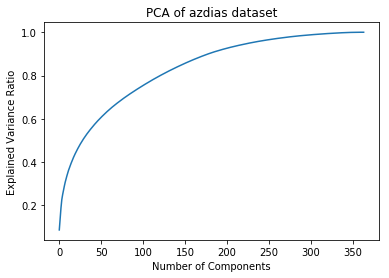

In [7]:
plt.plot(cummulative_evr_array)
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA of azdias dataset')
plt.show();

In [8]:
indices_evr_lt_90 = np.where(cummulative_evr_array<=0.90)
indices_evr_gt_90 = np.where(cummulative_evr_array>0.90)

In [9]:
indices_evr_lt_90[0][-1]

177

In [10]:
customers_pca = pca.transform(customers)

In [11]:
pca_177 = PCA(random_state=randomState, n_components=177)

In [ ]:
azdias_pca_177 = pca_177.fit_transform(azdias)
customers_pca_177 = pca_177.transform(customers)

In [ ]:
plt.bar(range(0,len(pca_177.explained_variance_ratio_)), pca_177.explained_variance_ratio_, alpha=0.5, align='center', label='Individual explained variance')
# plt.step(range(0,len(np.cumsum(pca_177.explained_variance_ratio_))), np.cumsum(pca_177.explained_variance_ratio_), where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [ ]:
def get_feature_weights(pca_var, df, component):
    component = 0
    features = df.columns.values
    featureWeights = pca_var.components_[component]

    feature_weight_dict = {feature: weight for feature, weight in zip(features, featureWeights)}

    feature_weights_df = pd.DataFrame({'weights':feature_weight_dict}).reset_index().sort_values('weights', ascending=False)

    return feature_weights_df

In [ ]:
feature_weights_0 = get_feature_weights(pca_177, azdias, 0)

In [ ]:
feature_weights_0.iloc[[0,1,2,-1,-2,-3], :]

TypeError: <lambda>() missing 1 required positional argument: 'height'

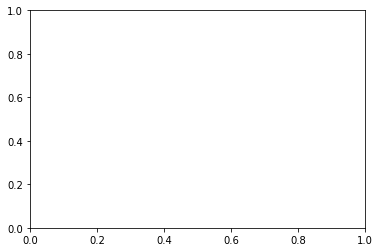

In [32]:
plt.bar(feature_weights_0, feature_weights_0.tail(3))
plt.bar(feature_weights_0.head(3))

<Container object of 3 artists>

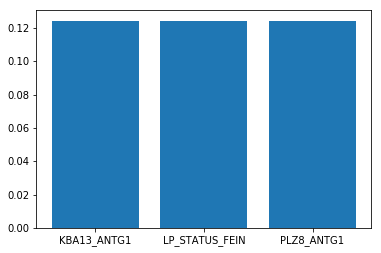

In [26]:
plt.bar(feature_weights_0.head(3)['index'], feature_weights_0.head(3).weights)


TypeError: <lambda>() missing 1 required positional argument: 'height'

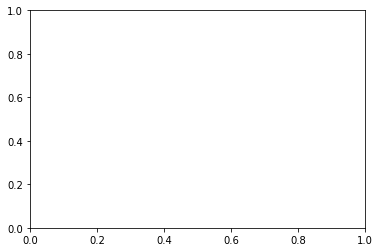

In [19]:
plt.bar(feature_weights_0.index, feature_weights_0.head(3))
feature_weights_0.tail(3).plot.bar()

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')